# Visualize entity statistics for annotated molecular dynamics texts 📊

### 🎯 Objectives
- Retrieve a dataframe summarizing, for each annotated text, the number of entities per class: MOLECULE (`MOL`), FORCEFIELD (`FFM`), SIMULATION_TIME (`STIME`), TEMPERATURE (`TEMP`), SOFTWARE NAME (`SOFTNAME`) and SOFTWARE VERSION (`SOFTVERS`).
- Get an overview of the entities present across all annotations.

## Load libraries

In [12]:
import math
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%load_ext watermark
%watermark
%watermark --packages numpy,pandas,matplotlib,seaborn

Last updated: 2025-12-02T11:41:41.873996+01:00

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 8.13.2

Compiler    : Clang 20.1.4 
OS          : Linux
Release     : 6.8.0-51-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

numpy     : 2.3.4
pandas    : 2.2.3
matplotlib: 3.10.7
seaborn   : 0.13.2



In [4]:
# Directories and files.
RESULTS_FILE = Path("../results/all_annotations_entities_count.tsv")
ANNOTATION_DIR = Path("../annotations/v2")

## Load results

In [5]:
def load_tsv(path: Path) -> pd.DataFrame:
    """Load a TSV file into a pandas DataFrame.

    Parameters
    ----------
    path : Path
        The filesystem path to the TSV file.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the contents of the TSV file.
    """
    df = pd.read_csv(path, sep="\t")
    return df


df = load_tsv(RESULTS_FILE)
df

,filename,text_length,TEMP_nb,SOFTNAME_nb,SOFTVERS_nb,STIME_nb,MOL_nb,FFM_nb
0,figshare_14156828.json,2144,0,0,0,0,38,0
1,figshare_14225919.json,1591,0,0,0,0,9,12
2,zenodo_1346073.json,1034,0,1,0,0,3,0
3,zenodo_3613573.json,924,0,0,0,4,11,2
4,figshare_7924394.json,1174,0,0,0,1,8,0
...,...,...,...,...,...,...,...,...
375,zenodo_6970327.json,1396,0,6,0,0,21,0
376,figshare_14919822.json,1317,0,0,0,0,14,0
377,figshare_5546158.json,1074,0,0,0,1,8,1
378,figshare_15054454.json,1070,0,0,0,0,1,0


## Global distribution of classes

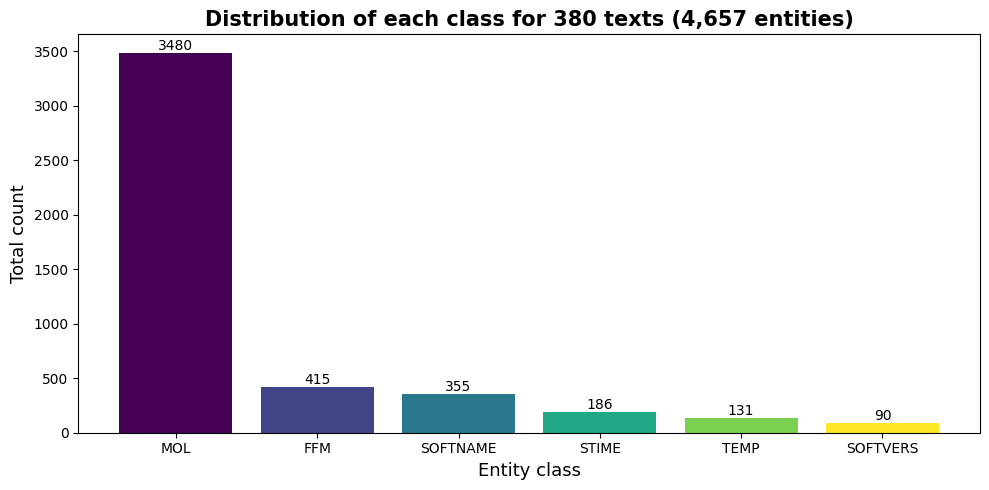

In [13]:
def plot_class_distribution(df: pd.DataFrame) -> None:
    """Plot a bar chart showing the total number of entities per class across all files.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing columns ending with ``_nb`` representing
        the counts of each entity class.
    """
    total_entities = len(df)
    cols = [col for col in df.columns if col.endswith("_nb")]
    summary = df[cols].sum().sort_values(ascending=False)

    classes = [col.replace("_nb", "") for col in summary.index]
    counts = summary.to_numpy()

    cmap = matplotlib.colormaps.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, len(classes)))

    plt.figure(figsize=(10, 5))
    x = np.arange(len(classes))
    bars = plt.bar(x, counts, color=colors)
    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.0f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.title(
        f"Distribution of each class for {total_entities} texts ({np.sum(counts):,} entities)",
        fontsize=15,
        fontweight="bold",
    )
    plt.xlabel("Entity class", fontsize=13)
    plt.ylabel("Total count", fontsize=13)
    plt.xticks(x, classes)
    plt.tight_layout()
    plt.show()


plot_class_distribution(df)

## Distribution per class

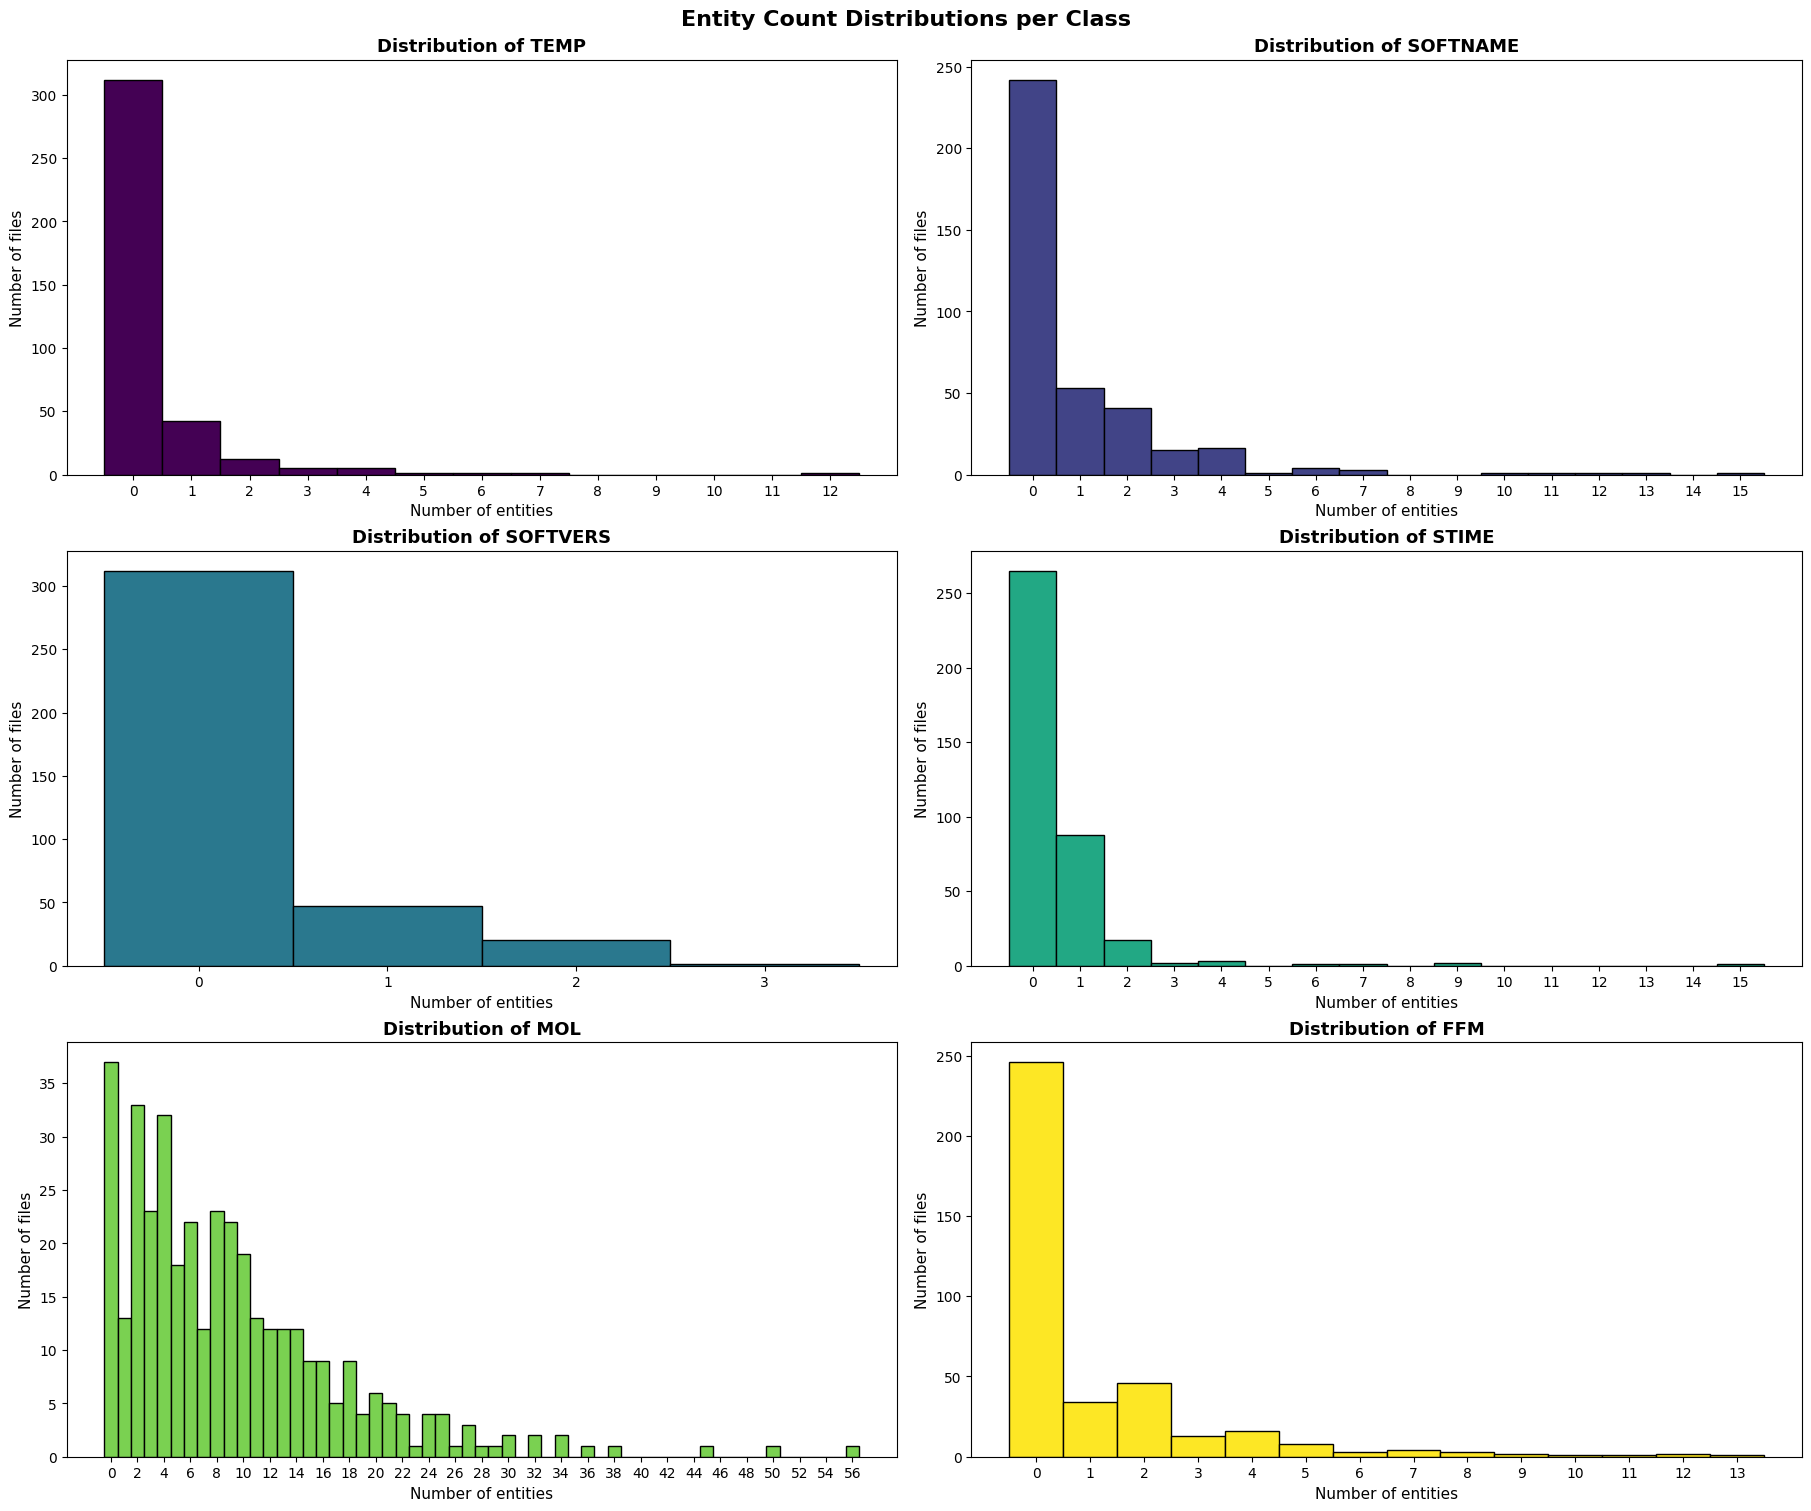

In [ ]:
def plot_histograms(df: pd.DataFrame) -> None:
    """Plot histograms of entity counts per class.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns ending with '_nb' = counts of each entity class.
    """
    cols = [col for col in df.columns if col.endswith("_nb")]
    n_classes = len(cols)

    cmap = matplotlib.colormaps.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, n_classes))

    n_cols = 2
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(18, 5 * n_rows),
        constrained_layout=True
    )
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        data = df[col]
        max_val = int(data.max())

        # Histogram
        bins = np.arange(0, max_val + 2) - 0.5
        ax.hist(
            data,
            bins=bins,
            color=colors[i],
            edgecolor="black",
        )
        # Adaptive steps for MOL
        step = 1 if max_val <= 20 else 2
        ax.set_xticks(np.arange(0, max_val + 1, step))

        ax.set_title(
            f"Distribution of {col.replace('_nb', '')}",
            fontsize=13,
            fontweight="bold",
        )
        ax.set_xlabel("Number of entities", fontsize=11)
        ax.set_ylabel("Number of files", fontsize=11)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Entity Count Distributions per Class", fontsize=16, fontweight="bold")
    plt.show()


plot_histograms(df)